In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Leitura do Excel e conversão das variáveis na primeira linha para strings
df = pd.read_excel("Narrative_MP_Brazil_Dataset_with_Controls.xlsx", sheet_name="IPCA")
df.iloc[0] = df.iloc[0].astype(str)

# Coerção das colunas (exceto 'Data') para numéricas
df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric, errors='coerce')

# Criando a variável de data
df['date'] = pd.to_datetime(df['Data'], format='%d-%m-%Y')

# Formatando a variável de data
df['date'] = df['date'].dt.to_period('M')

# Ordenando o DataFrame pela variável de data
df = df.sort_values('date')

# Configurando a série temporal
df = df.set_index('date')

# Descartando a variável 'Data'
df = df.drop(columns=['Data'])


In [11]:
df.head()

,Selic,Selic_d,ibcbr,ibcbrsa,ibcbrsa_log,pim,pimsa,pimsa_log,pmcsa,pmcsa_log,...,fgv_ind,fgv_ind_log,fgv_serv,fgv_serv_log,logbrlem,logfci,ff4_tc,Choque,Choque_pos,Choque_neg
date,,,,,,,,,,,,,,,,,,,,,
2006-01,17.25,0.00,108.55,113.36,4.730569,83.65213,90.63329,4.506822,55.37375,4.014106,...,120.771282,4.793899,133.507340,4.894156,3.821372,4.608255,-0.177879,0.073583,0.073583,0.073583
2006-02,17.25,0.00,107.80,113.64,4.733036,80.20779,91.37976,4.515024,54.72103,4.002248,...,121.915021,4.803324,133.479233,4.893946,3.861958,4.609486,0.000000,0.000000,0.000000,0.000000
2006-03,16.50,-0.75,119.09,113.56,4.732331,92.39900,90.76299,4.508252,54.81225,4.003914,...,121.594866,4.800695,133.933161,4.897341,3.851362,4.611407,-0.075017,-0.034759,-0.034759,-0.034759
2006-04,15.75,-0.75,112.61,114.24,4.738301,85.66672,91.32689,4.514445,55.45193,4.015517,...,119.820464,4.785994,135.860118,4.911626,3.875185,4.609333,0.018302,0.002962,0.002962,0.002962
2006-05,15.75,0.00,117.19,115.65,4.750568,95.35205,91.89632,4.520661,55.72637,4.020453,...,120.083283,4.788186,134.599264,4.902302,3.809868,4.609002,0.000000,0.000000,0.000000,0.000000


In [12]:
# Renomeando colunas
df.rename(columns={'logbrlem': 'log_brlem', 'logfci': 'log_fci', 'ipca_log': 'log_ipca',
                   'pimsa_log': 'log_pimsa', 'ibcbrsa': 'log_ibcbrsa'}, inplace=True)


# Criando variáveis de mudanças percentuais mensais (MoM)
df['D_log_ipca'] = df['log_ipca'].diff()
df['D_log_pimsa'] = df['log_pimsa'].diff()
df['D_log_brlem'] = df['log_brlem'].diff()
df['D_log_fci'] = df['log_fci'].diff()

# Criando variáveis de mudanças percentuais anuais (YoY)
df['YoY_selic'] = df['Selic'] - df['Selic'].shift(12)
df['YoY_ipca'] = df['log_ipca'] - df['log_ipca'].shift(12)
df['YoY_pimsa'] = df['log_pimsa'] - df['log_pimsa'].shift(12)

# Criando variáveis de mudanças nas somas dos últimos seis meses (SoS)
df['SoS_selic'] = df['Selic'] - df['Selic'].shift(6)
df['SoS_ipca'] = df['log_ipca'] - df['log_ipca'].shift(6)
df['SoS_pimsa'] = df['log_pimsa'] - df['log_pimsa'].shift(6)

# Criando variáveis de mudanças nas somas dos últimos três meses (QoQ)
df['QoQ_selic'] = df['Selic'] - df['Selic'].shift(3)
df['QoQ_ipca'] = df['log_ipca'] - df['log_ipca'].shift(3)
df['QoQ_pimsa'] = df['log_pimsa'] - df['log_pimsa'].shift(3)



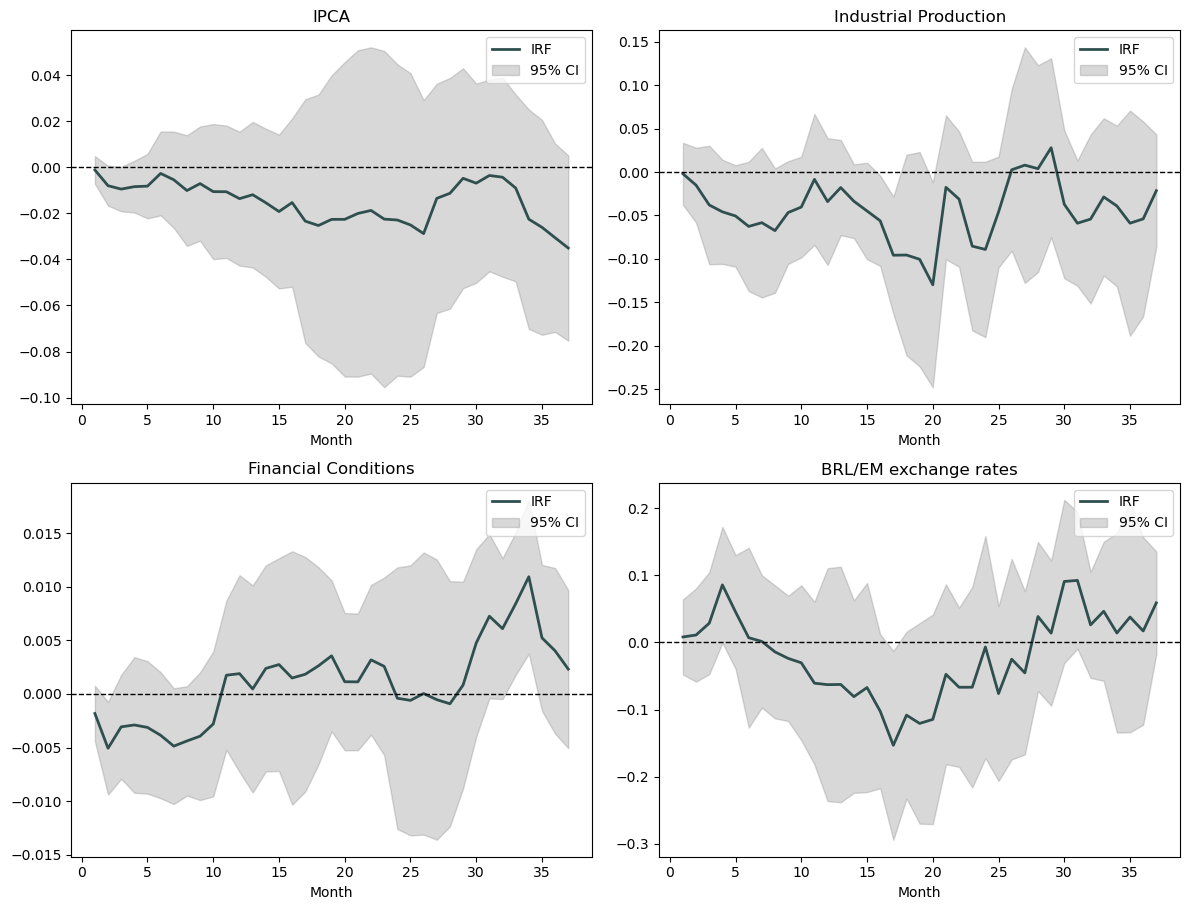

In [21]:
# Definindo o número de lags para suas variáveis de controle
controls_lag = 2

# Definindo o horizonte = 36
horizon = range(1, 38)

# Adicionando variáveis defasadas ao DataFrame
list_var = ["log_ipca", "log_pimsa", "log_fci", "log_brlem"]
list_control = ["Selic", "log_ipca", "log_pimsa", "log_fci", "log_brlem"]

# Dicionário para armazenar os resultados
results_dict = {var: {"betas": [], "ses": []} for var in list_var}

# Configurando subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#fig.suptitle('Impulse Response Functions (IRFs)')

for i, variable in enumerate(list_var):
    for month in horizon:
        df["LP_lhs"] = df[variable].diff(month)
        df["LP_lhs"] = df["LP_lhs"].shift(-month + 1)

        for lag in range(1, controls_lag + 1):
            for control in list_control:
                df[f"L{lag}.{control}"] = df[control].shift(lag)

        # Construindo a fórmula da regressão
        lagged_controls = [f"L{i}.{control}" for i in range(1, controls_lag + 1) for control in list_control]
        lagged_controls_str = ' + '.join([f"df['{control}']" for control in lagged_controls])

        formula = f"df['LP_lhs'] ~ df['Choque'] + {lagged_controls_str}"
        nw_lag_truncation = month + 1

        # Executando a regressão com erros padrão robustos
        model = sm.OLS.from_formula(formula, data=df).fit(cov_type='HAC', cov_kwds={'maxlags': nw_lag_truncation})
        results_dict[variable]["betas"].append(model.params['df[\'Choque\']'])
        results_dict[variable]["ses"].append(model.bse['df[\'Choque\']'])

    # Plotando as IRFs no subplot correspondente
    ax = axs[i // 2, i % 2]

    LP_b_lhs_var = results_dict[variable]["betas"]
    LP_se_lhs_var = results_dict[variable]["ses"]

    # Plotando a linha central
    ax.plot(horizon, LP_b_lhs_var, label='IRF', color='DarkSlateGray', linewidth=2)

    # Preenchendo a área entre o intervalo de confiança
    ax.fill_between(horizon, np.array(LP_b_lhs_var) - 1.96 * np.array(LP_se_lhs_var),
                    np.array(LP_b_lhs_var) + 1.96 * np.array(LP_se_lhs_var), color='gray', alpha=0.3, label='95% CI')

    # Adicionando uma linha em y = 0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # Adicionando rótulos e títulos
    ax.set_title(f'{variable}')
    ax.set_xlabel('Month')
    #ax.set_ylabel(f'Cumulated change in log {variable}')

    # Adicionando uma legenda
    ax.legend()

# Ajustando o layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[0, 0].set_title('IPCA')
axs[0, 1].set_title('Industrial Production')
axs[1, 0].set_title('Financial Conditions')
axs[1, 1].set_title('BRL/EM exchange rates')

# Exportar o gráfico como um arquivo PNG
plt.savefig('brw_IRF_LP.png', dpi=300, bbox_inches='tight')

# Exibindo os subplots
plt.show()
